In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from builtins import range
from random import shuffle

## Example: Two-layer net

In [ ]:
class TwoLayerNet:

  def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
    # initialize the weights
    self.params = {}
    self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

  def predict(self, x):
    W1, W2 = self.params['W1'], self.params['W2']
    b1, b2 = self.params['b1'], self.params['b2']

    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    y = softmax(a2)

    return y

  # x : input data, t : ground-truth
  def loss(self, x, t):
    y = self.predict(x)

    return cross_entropy_error(y, t)

  def accuracy(self, x, t):
    y = self.predict(x)
    y = np.argmax(y, axis=1)
    t = np.argmax(t, axis=1)

    accuracy = np.sum(y == t) / float(x.shape[0])
    return accuracy

  # x : input data, t : ground-truth
  def numerical_gradient(self, x, t):
    loss_W = lambda W: self.loss(x, t)

    grads = {}
    grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
    grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
    grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
    grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

    return grads

  def gradient(self, x, t):
    W1, W2 = self.params['W1'], self.params['W2']
    b1, b2 = self.params['b1'], self.params['b2']
    grads = {}

    batch_num = x.shape[0]

    # forward
    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    y = softmax(a2)

    # backward
    dy = (y - t) / batch_num

    # 'ppp' exercise
    grads['W2'] = np.dot(z1.T, dy)
    grads['b2'] = np.sum(dy, axis=0)

    da1 = np.dot(dy, W2.T)
    dz1 = sigmoid_grad(a1) * da1
    grads['W1'] = np.dot(x.T, dz1)
    grads['b1'] = np.sum(dz1, axis=0)

    return grads

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))


def sigmoid_grad(x):
  return (1.0 - sigmoid(x)) * sigmoid(x)


def softmax(x):
  if x.ndim == 2:
    x = x.T
    x = x - np.max(x, axis=0)
    y = np.exp(x) / np.sum(np.exp(x), axis=0)
    return y.T

  x = x - np.max(x)  # to void overflow
  return np.exp(x) / np.sum(np.exp(x))


def cross_entropy_error(y, t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)

  if t.size == y.size:
    t = t.argmax(axis=1)

  batch_size = y.shape[0]

  return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [ ]:
try:
    import urllib.request
except ImportError:
    raise ImportError('You should use Python 3.x')
import os.path
import gzip
import pickle
import os
import numpy as np


url_base = 'https://github.com/WegraLee/deep-learning-from-scratch/raw/master/dataset/'
key_file = {
  'train_img':'train-images-idx3-ubyte.gz',
  'train_label':'train-labels-idx1-ubyte.gz',
  'test_img':'t10k-images-idx3-ubyte.gz',
  'test_label':'t10k-labels-idx1-ubyte.gz'
}

dataset_dir = '/content'  # Colab base dir
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784


def _download(file_name):
  file_path = dataset_dir + "/" + file_name

  if os.path.exists(file_path):
      return

  print("Downloading " + file_name + " ... ")
  urllib.request.urlretrieve(url_base + file_name, file_path)
  print("Done")

def download_mnist():
  for v in key_file.values():
    _download(v)

def _load_label(file_name):
  file_path = dataset_dir + "/" + file_name

  print("Converting " + file_name + " to NumPy Array ...")
  with gzip.open(file_path, 'rb') as f:
    labels = np.frombuffer(f.read(), np.uint8, offset=8)
  print("Done")

  return labels

def _load_img(file_name):
  file_path = dataset_dir + "/" + file_name

  print("Converting " + file_name + " to NumPy Array ...")
  with gzip.open(file_path, 'rb') as f:
    data = np.frombuffer(f.read(), np.uint8, offset=16)
  data = data.reshape(-1, img_size)
  print("Done")

  return data

def _convert_numpy():
  dataset = {}
  dataset['train_img'] =  _load_img(key_file['train_img'])
  dataset['train_label'] = _load_label(key_file['train_label'])
  dataset['test_img'] = _load_img(key_file['test_img'])
  dataset['test_label'] = _load_label(key_file['test_label'])

  return dataset

def init_mnist():
  download_mnist()
  dataset = _convert_numpy()
  print("Creating pickle file ...")
  with open(save_file, 'wb') as f:
    pickle.dump(dataset, f, -1)
  print("Done!")

def _change_one_hot_label(X):
  T = np.zeros((X.size, 10))
  for idx, row in enumerate(T):
    row[X[idx]] = 1

  return T


def load_mnist(normalize=True, flatten=True, one_hot_label=False):
  """Read MNIST

  Parameters
  ----------
  normalize : Image pixel values become 0.0~1.0
  one_hot_label :
    encodes labels as one hot vectores
    an example of an one-hot : [0,0,1,0,0,0,0,0,0,0]
  flatten : makes the images 1-D vectors

  Returns
  -------
  (Train Images, Train Labels), (Test Images, Test Images)
  """
  if not os.path.exists(save_file):
      init_mnist()

  with open(save_file, 'rb') as f:
      dataset = pickle.load(f)

  if normalize:
      for key in ('train_img', 'test_img'):
          dataset[key] = dataset[key].astype(np.float32)
          dataset[key] /= 255.0

  if one_hot_label:
      dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
      dataset['test_label'] = _change_one_hot_label(dataset['test_label'])

  if not flatten:
        for key in ('train_img', 'test_img'):
          dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

  return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label'])

train acc, test acc | 0.0993, 0.1032
train acc, test acc | 0.7920, 0.7976
train acc, test acc | 0.8777, 0.8808
train acc, test acc | 0.8978, 0.9006
train acc, test acc | 0.9074, 0.9085
train acc, test acc | 0.9132, 0.9147
train acc, test acc | 0.9180, 0.9190
train acc, test acc | 0.9224, 0.9232
train acc, test acc | 0.9255, 0.9278
train acc, test acc | 0.9297, 0.9300
train acc, test acc | 0.9327, 0.9336
train acc, test acc | 0.9357, 0.9356
train acc, test acc | 0.9393, 0.9379
train acc, test acc | 0.9413, 0.9398
train acc, test acc | 0.9435, 0.9424
train acc, test acc | 0.9457, 0.9441
train acc, test acc | 0.9470, 0.9451


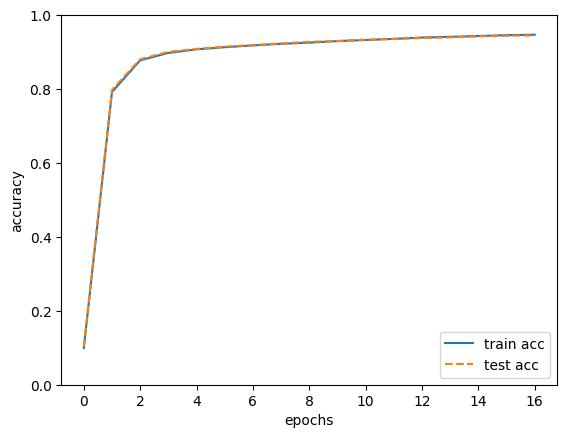

In [ ]:
# read data
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# hyper-parameters
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# iteration per epoch
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
  # get minibatch
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  t_batch = t_train[batch_mask]

  # gradient calculation
  #grad = network.numerical_gradient(x_batch, t_batch)
  grad = network.gradient(x_batch, t_batch)

  # update parameters
  for key in ('W1', 'b1', 'W2', 'b2'):
    network.params[key] -= learning_rate * grad[key]

  # record training process
  loss = network.loss(x_batch, t_batch)
  train_loss_list.append(loss)

  # log accuracy at the end of each epoch
  if i % iter_per_epoch == 0:
    train_acc = network.accuracy(x_train, t_train)
    test_acc = network.accuracy(x_test, t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(f"train acc, test acc | {train_acc:.4f}, {test_acc:.4f}")

# plot the result
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## Activation functions

In [ ]:
class Relu:
  def __init__(self):
    self.mask = None

  def forward(self, x):
    self.mask = (x <= 0)
    out = x.copy()
    out[self.mask] = 0

    return out

  def backward(self, dout):
    dout[self.mask] = 0
    dx = dout

    return dx


# 'ppp' exercise
class Sigmoid:
  def __init__(self):
    self.out = None

  def forward(self, x):
    out = sigmoid(x)
    self.out = out
    return out

  def backward(self, dout):
    dx = dout * (1.0 -self.out) * self.out
    return dx


In [ ]:
# 'ppp' exercise
class Affine:
  def __init__(self, W, b):
    self.W = W
    self.b = b

    self.x = None
    self.original_x_shape = None

    self.dW = None
    self.db = None

  def forward(self, x):
    self.original_x_shape = x.shape
    x = x.reshape(x.shape[0], -1)
    self.x = x

    out = np.dot(self.x, self.W) + self.b
    return out

  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.x.T, dout)
    self.db = np.sum(dout, axis=0)

    dx = dx.reshape(*self.original_x_shape)
    return dx


